# 语义分割(semantic segmentation)

语义分割
- 语义分割将图片中的每个像素分类到对应的类别

总结
- 语义分割通过将图像划分为属于不同语义类别的区域，来识别并理解图像中像素级别的内容
- 语义分割的一个重要数据集叫做Pascal VOC2012
- 由于语义分割的输入图像和标签在像素上一一对应，输入图像会被随机裁剪成为固定尺寸而不是对图像进行放缩操作

In [1]:
#导入第三方库
%matplotlib inline
import os, torch, torchvision
from d2l import torch as d2l

In [2]:
#下载并解压VOC数据集
d2l.DATA_HUB['voc2012'] = (d2l.DATA_URL + 'VOCtrainval_11-May-2012.tar',
                           '4e443f8a2eca6b1dac8a6c57641b67dd40621a49')
voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')

In [3]:
#将所有的输入图像和标签读入内存
#默认读取训练集
def read_voc_images(voc_dir, is_train= True):
    """读取所有的输入图像和标签"""
    #定义文件路径
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation', 
                             'train.txt' if is_train else 'val.txt')
    #使用RGB模式读取图像
    mode = torchvision.io.image.ImageReadMode.RGB
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [], []
    for i, fname in enumerate(images):
        #添加特征
        features.append(torchvision.io.read_image(os.path.join(voc_dir, 
                        'JPEGImages', f'{fname}.jpg')))
        #添加图像标签(使用RGB模式读取)
        labels.append(torchvision.io.read_image(os.path.join(voc_dir, 
                      'SegmentationClass', f'{fname}.png'), mode))
    return features, labels

train_features, train_labels = read_voc_images(voc_dir, is_train= True)

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

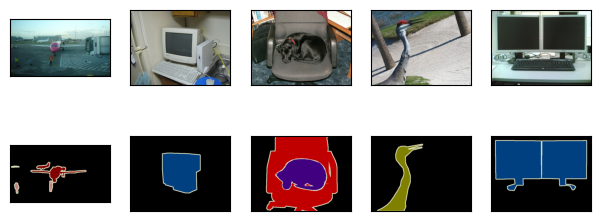

In [4]:
#绘制前五个图像及其对应的标签
n = 5
imgs = train_features[0: n] + train_labels[0: n]
imgs = [img.permute(1, 2, 0) for img in imgs]
d2l.show_images(imgs, 2, n)

In [5]:
#列举颜色值及其对应的物体类别
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]] 

VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

In [6]:
#构建从上述RGB颜色(colormap)到类别索引的映射
def voc_colormap2label():
    """构建RGB颜色值到类别索引的映射"""
    colormap2label = torch.zeros(256 ** 3, dtype= torch.long)
    for i, colormap in enumerate(VOC_COLORMAP):
        colormap2label[(
            colormap[0]* 256 + colormap[1]) * 256 + colormap[2]] = i
    return colormap2label

#将RGB值映射到VOC2012数据集中的类别索引(classes)
def voc_label_indices(colormap, colormap2label):
    """将VOC标签中的RGB值映射到它们对应的类别索引中"""
    colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
    idx = ((colormap[:, :, 0]* 256 + colormap[:, :, 1])* 256 + colormap[:, :, 2])
    return  colormap2label[idx]

In [7]:
#样例展示
y = voc_label_indices(train_labels[0], colormap2label= voc_colormap2label())
y[105:115, 130:140], VOC_CLASSES[1]

(tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]),
 'aeroplane')

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

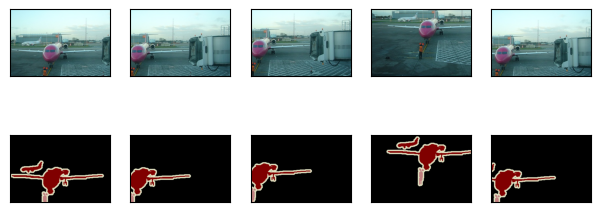

In [8]:
#进行数据预处理
#在此处不能采用缩放，因为缩放操作导致label无法对应原图中的像素
#故在语义分割中一般将图像裁剪成指定大小，label也需要对应操作
def voc_rand_crop(feature, label, height, width):
    """随机裁剪特征和标签图像"""
    #指定裁剪大小
    rect = torchvision.transforms.RandomCrop.get_params(feature, (height, width))
    feature = torchvision.transforms.functional.crop(feature, *rect)
    label = torchvision.transforms.functional.crop(label, *rect)
    return feature, label

#指定随机裁剪次数
n = 5
imgs = []
#以第一个标签为例进行裁剪
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)

imgs = [img.permute(1, 2, 0) for img in imgs]
#将对应的裁剪按列展示
d2l.show_images(imgs[::2] + imgs[1::2], 2, n)

In [9]:
#自定义语义分割数据集类VOCSegDataset
class VOCSegDataset(torch.utils.data.Dataset):
    """一个用于加载VOC数据集的自定义类"""
    def __init__(self, is_train, crop_size, voc_dir):
        """初始化函数继承Dataset类,
        is_train代表是否为数据集,crop_size指定裁剪大小
        """
        self.transform = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                          std=[0.229, 0.224, 0.225])
        self.crop_size = crop_size
        features, labels = read_voc_images(voc_dir, is_train= is_train)
        self.features = [self.normalize_image(feature) 
                         for feature in self.filter(features)]
        self.labels = self.filter(labels)
        self.colormap2label = voc_colormap2label()
        print('read ' + str(len(self.features)) + ' examples')
    
    def normalize_image(self, img):
        """标准化图像"""
        return self.transform(img.float() / 255)
        
    def filter(self, imgs):
        """过滤原始图像大小小于裁剪尺寸要求的图像"""
        return [img for img in imgs if(
                img.shape[1] >= self.crop_size[0] and
                img.shape[2] >= self.crop_size[1])]
    
    def __getitem__(self, idx):
        """创建图像每个像素对应的索引"""
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx], 
                                       *self.crop_size)
        return (feature, voc_label_indices(label, self.colormap2label))
    
    def __len__(self):
        return len(self.features)

In [10]:
crop_size = (320, 480)
voc_train = VOCSegDataset(True, crop_size, voc_dir)
voc_test = VOCSegDataset(False, crop_size, voc_dir)

read 1114 examples
read 1078 examples


In [11]:
batch_size = 64
#创建训练器
train_iter = torch.utils.data.DataLoader(voc_train, batch_size, shuffle= True, 
                                         drop_last= True)
for X, Y in train_iter:
    print(X.shape)
    print(Y.shape)
    break        

torch.Size([64, 3, 320, 480])
torch.Size([64, 320, 480])


In [12]:
#定义load_data_voc函数来下载并读取Pascal VOC2012语义分割数据集
def load_data_voc(batch_size, crop_size):
    """加载VOC语义分割数据集"""
    voc_dir = d2l.download_extract('voc2012', os.path.join('VOCdevkit', 'VOC2012'))
    train_iter = torch.utils.data.DataLoader(VOCSegDataset(True, crop_size, voc_dir), 
                                             batch_size, shuffle= True, drop_last= True)
    train_iter = torch.utils.data.DataLoader(VOCSegDataset(False, crop_size, voc_dir), 
                                             batch_size, shuffle= False, drop_last= False)
    return train_iter, test_iter